<a href="https://colab.research.google.com/github/daniloc7/LogR_PSO/blob/main/LogR_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install pyswarm
!pip install pyswarms

In [5]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import numpy as np
import pyswarms as ps
from matplotlib import pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss


In [ ]:
# Loading the data
# data = pd.read_csv('/content/diabetes.csv')
data = pd.read_csv('/content/sample_data/AID362red_train.csv')
print(data.shape)
X = data.drop('Outcome', axis=1)
y = data['Outcome']

In [ ]:
#contagem das classes
class_counts = data['Outcome'].value_counts()

print(class_counts)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
clf = LogisticRegression(solver='liblinear', fit_intercept=True, max_iter=1000, penalty='l2', random_state=42, class_weight = 'balanced')
# clf = LogisticRegression(solver='liblinear', fit_intercept=True, max_iter=1000, penalty='l2', random_state=42, class_weight = 'balanced')
clf.fit(X_train, y_train) #treina o modelo, vai ser realizado um ajuste parar determinar os coeficientes
predictions = clf.predict(X_test)


In [ ]:
cm = confusion_matrix(y, clf.predict(X))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predito 0s', 'Predito 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Atual 0s', 'Atual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
  for j in range(2):
    ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [ ]:
#validação cruzada para comparação
# def optimize(X_train, y_train):

#    #a função grid_search vai realizar os testes com esses valores abaixo de C, o que for melhor, é salvo em C_opt
#     param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

#     model = LogisticRegression(solver='liblinear', fit_intercept=True, penalty='l2')

#     grid_search = GridSearchCV(model, param_grid, scoring='balanced_accuracy', cv=5)

#     grid_search.fit(X_train, y_train)

#     # pega o melhor parametro para otimizar
#     print(grid_search.best_params_['C'])
#     return grid_search.best_params_['C']

#
# C_opt = optimize(X_train, y_train)
# print(optimize)

# print('Melhor valor C:', C_opt)

In [ ]:
# # MAIS DIMENSOES
def optimize(X, y):
    n_particles = 100
    dimensions = X.shape[1]  # numeros de colunas(coeficientes)
    bounds = (np.array([0.01] * dimensions), np.array([10] * dimensions))
    options = {'c1': 1.496180, 'c2': 1.496180, 'w': 0.729844} #Cognitive coefficient Social coefficient Inertia coefficient
    optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, bounds=bounds, options=options)

    def fitness_function(coefficients, X_train, y_train):
        model = LogisticRegression(solver='liblinear', fit_intercept=True)
        model.coef_ = coefficients.reshape(1, -1)

        model.fit(X_train, y_train)
        predictions = model.predict(X_train)
        # print('Score Antigo: '+str(balanced_accuracy_score(y,predictions)))
        return -balanced_accuracy_score(y_train,predictions)

    cost, theta = optimizer.optimize(lambda x: fitness_function(x, X_train, y_train), iters=100)
    return theta

optimized_params = optimize(X_train, y_train)
optimized_params.sort()
print(optimized_params)



In [ ]:
#Mais dimensoes
#C=(optimized_params[0])
#C=C_opt
# logreg = LogisticRegression(solver='liblinear', fit_intercept=True, C=optimized_params[0], penalty='l2', class_weight='balanced', max_iter= 1000)  # logreg.coef_ = optimized_params.reshape(1, -1)
logreg = LogisticRegression(solver='liblinear', fit_intercept=True, C=optimized_params[0], penalty='l2', class_weight='balanced', max_iter= 1000)
logreg.coef_ = optimized_params.reshape(1, -1) #define os parametros otimizados pelo PSO
logreg.fit(X_train, y_train)

In [ ]:
y_pred_dps = logreg.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
print(classification_report(y_test, y_pred_dps, zero_division=1))
print('Score Antigo: '+str(balanced_accuracy_score(y_test, predictions)))
print('Score Novo: '+str(balanced_accuracy_score(y_test, y_pred_dps)))

# print('Score usando .score: '+str(logreg.score(X,y)))

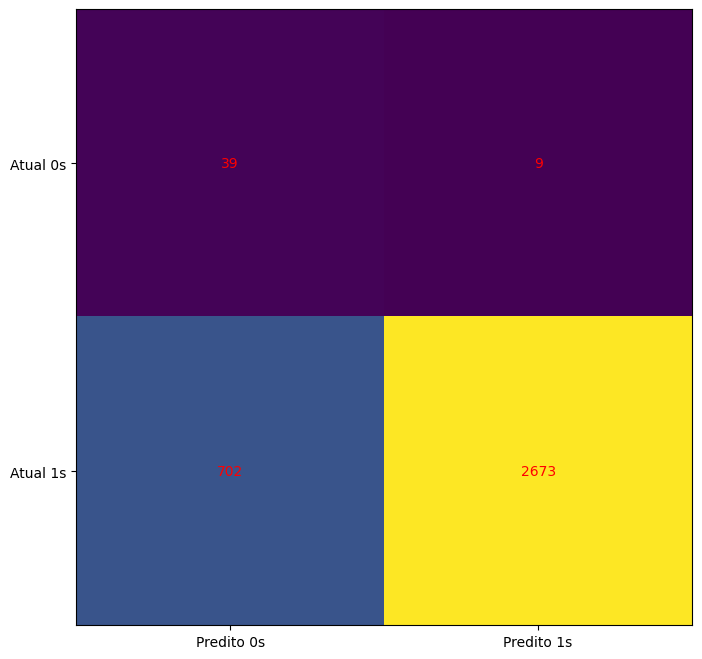

In [44]:
cm = confusion_matrix(y, logreg.predict(X))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predito 0s', 'Predito 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Atual 0s', 'Atual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
  for j in range(2):
    ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()